In [1]:
!pip install earthpy  gdal

     |████████████████████████████████| 1.4MB 2.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 19.1MB 1.3MB/s 
     |████████████████████████████████| 1.0MB 48.7MB/s 
     |████████████████████████████████| 6.5MB 41.6MB/s 
     |████████████████████████████████| 14.8MB 269kB/s 
  Created wheel for earthpy: filename=earthpy-0.9.2-cp37-none-any.whl size=1365089 sha256=5261dbf8abd9e67606d1ac5c40a08ebcc6f4a27134ec3c51c9b6b78cd9bb32d8
  Stored in directory: /root/.cache/pip/wheels/27/f9/a5/026bb95ef7b12f9343b842da6897b4001c5b902550095cbbbe
Successfully built earthpy


**Import Modules**

In [2]:
from glob import glob

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from scipy.io import loadmat
from sklearn.metrics import classification_report, accuracy_score

import plotly.graph_objects as go

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/FINAL PROJECT/Data Folsom Lake/Sentinel-2

/content/drive/MyDrive/FINAL PROJECT/Data Folsom Lake/Sentinel-2


**Read Data**

In [9]:
Folsom_Lake_S_sentinel_bands = glob('/content/drive/MyDrive/FINAL PROJECT/Data Folsom Lake/Sentinel-2/Bands/*')
Folsom_Lake_S_sentinel_bands.sort()
Folsom_Lake_S_sentinel_bands


['/content/drive/MyDrive/FINAL PROJECT/Data Folsom Lake/Sentinel-2/Bands/Sentinel-2 L1C image on 2016-10-22 Band01.jpg',
 '/content/drive/MyDrive/FINAL PROJECT/Data Folsom Lake/Sentinel-2/Bands/Sentinel-2 L1C image on 2016-10-22 Band02.jpg',
 '/content/drive/MyDrive/FINAL PROJECT/Data Folsom Lake/Sentinel-2/Bands/Sentinel-2 L1C image on 2016-10-22 Band03.jpg',
 '/content/drive/MyDrive/FINAL PROJECT/Data Folsom Lake/Sentinel-2/Bands/Sentinel-2 L1C image on 2016-10-22 Band04.jpg',
 '/content/drive/MyDrive/FINAL PROJECT/Data Folsom Lake/Sentinel-2/Bands/Sentinel-2 L1C image on 2016-10-22 Band05.jpg',
 '/content/drive/MyDrive/FINAL PROJECT/Data Folsom Lake/Sentinel-2/Bands/Sentinel-2 L1C image on 2016-10-22 Band06.jpg',
 '/content/drive/MyDrive/FINAL PROJECT/Data Folsom Lake/Sentinel-2/Bands/Sentinel-2 L1C image on 2016-10-22 Band07.jpg',
 '/content/drive/MyDrive/FINAL PROJECT/Data Folsom Lake/Sentinel-2/Bands/Sentinel-2 L1C image on 2016-10-22 Band08.jpg',
 '/content/drive/MyDrive/FINAL P

In [11]:
l = []
for i in Folsom_Lake_S_sentinel_bands:
  with rio.open(i,'r') as f:
    l.append(f.read(1))

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:207: NotGeoreferencedWarning:

Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.



In [12]:
k=[]
for each_pic in l: 
  k.append(each_pic[:811, :1653])

In [13]:
arr_st = np.stack(k)

In [14]:
arr_st.shape

(13, 811, 1653)

# **Visualize Data**
**Bands**

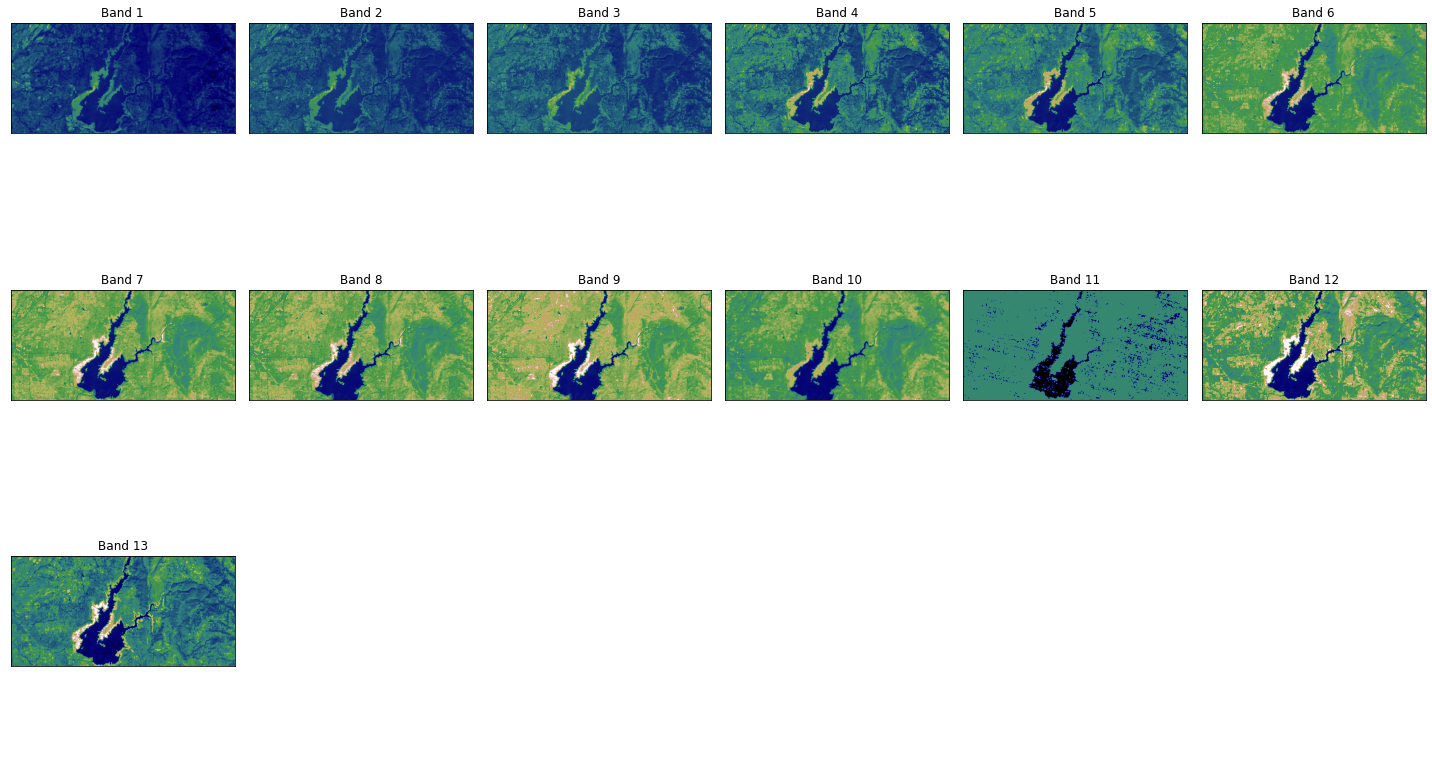

In [15]:
ep.plot_bands(arr_st, cmap = 'gist_earth', figsize = (20, 12), cols = 6, cbar = False)
plt.show()

**RGB Composite Image**

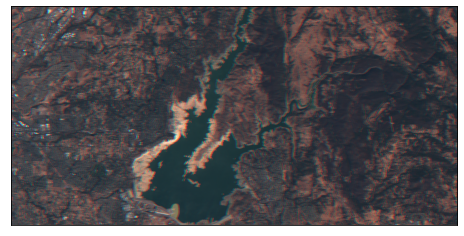

In [16]:
rgb = ep.plot_rgb(arr_st, 
                  rgb=(3,2,1), 
                  figsize=(8, 10), 
                  # title='RGB Composite Image'
                  )

plt.show()

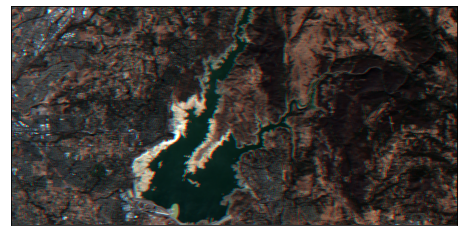

In [17]:

ep.plot_rgb(
    arr_st,
    rgb=(3, 2, 1),
    stretch=True,
    str_clip=0.2,
    figsize=(8, 10),
    # title="RGB Composite Image with Stretch Applied",
)

plt.show()

**Data Distribution of Bands**

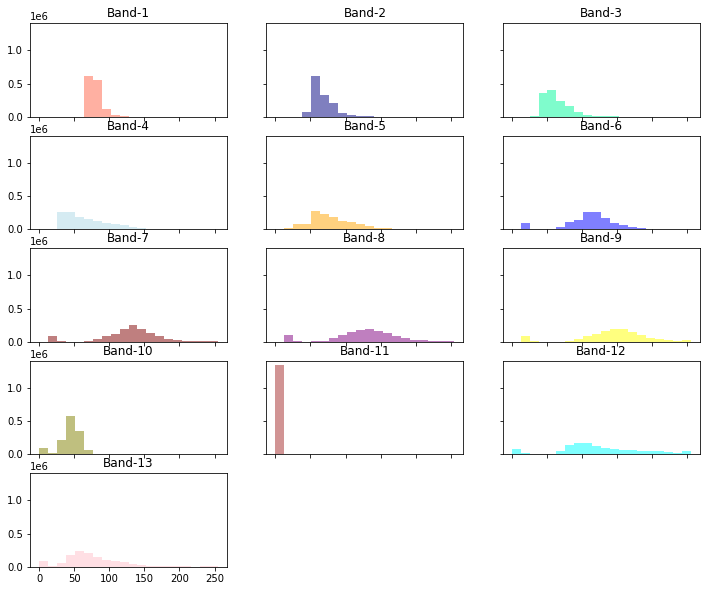

In [18]:
colors = ['tomato', 'navy', 'MediumSpringGreen', 'lightblue', 'orange', 'blue',
          'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan', 'pink']

ep.hist(arr_st, 
         colors = colors,
        title=[f'Band-{i}' for i in range(1, 14)], 
        cols=3, 
        alpha=0.5, 
        figsize = (12, 10)
        )

plt.show()

**Preprocessing**

In [19]:
x = np.moveaxis(arr_st, 0, -1)
x.shape

(811, 1653, 13)

In [20]:
x.reshape(-1, 13).shape, 811*1653

((1340583, 13), 1340583)

In [21]:
from sklearn.preprocessing import StandardScaler

X_data = x.reshape(-1, 13)

scaler = StandardScaler().fit(X_data)

X_scaled = scaler.transform(X_data)

X_scaled.shape

(1340583, 13)

# **Principal Component Analysis (PCA)**

In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 4)

pca.fit(X_scaled)

data = pca.transform(X_scaled)

In [26]:
data.shape

(1340583, 4)

In [27]:
pca.explained_variance_ratio_

array([0.53356692, 0.182009  , 0.07218661, 0.05509332])

In [28]:
np.sum(pca.explained_variance_ratio_)

0.8428558492252012

# **Visualize Bands after PCA**

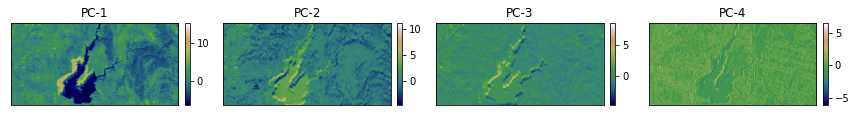

In [30]:
ep.plot_bands(np.moveaxis(data.reshape((811, 1653, data.shape[1])), -1, 0),
              cmap = 'gist_earth',
              cols = 4,
              title = [f'PC-{i}' for i in range(1,5)])

plt.show()

# k - Means

In [31]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 6, random_state = 11)

kmeans.fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=11, tol=0.0001, verbose=0)

In [32]:
labels = kmeans.predict(data)

In [33]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=int32)

# **Visualize Clusters**

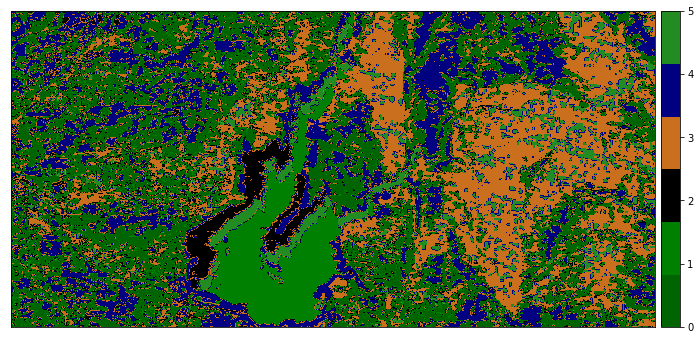

In [35]:
ep.plot_bands(labels.reshape(811, 1653), cmap=ListedColormap(['darkgreen', 'green', 'black', '#CA6F1E', 'navy', 'forestgreen']))
plt.show()

**Interactive plot using Plotly**

In [37]:
import plotly.express as px

fig = px.imshow(labels.reshape(811, 1653), 
          color_continuous_scale = ['darkgreen', 'green', 'black', '#CA6F1E', 'navy', 'forestgreen'])

fig.update_xaxes(showticklabels=False)

fig.update_yaxes(showticklabels=False)

fig.update_layout(
    autosize=False,
    width=500,
    height=1000,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    # paper_bgcolor="LightSteelBlue",
)